In [ ]:
!pip install requests
import pickle
import tweepy
import json
import requests
import datetime
import csv
from datetime import datetime

In [4]:
with open('pol_id_twitter_mapping.pkl', 'rb') as f:
    data = pickle.load(f)
    print(data[1])
    id_mappings = data

14200465


In [5]:
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAJtdwgEAAAAALDItqPytQn4LXfLvG%2FRU1U%2BUKW4%3DQD5FIUJjSf3nCCCFjpw4XKAwBCs8Q5YazvQ243cxlJVSjhiviZ'
api_key = 'MiRp3HV2FSpkeBJQBRDkBBw9a'
api_key_secret = 'LY3hVK8UWt8GGXHn1p034MLaM2yObQMlGEkc8DORW7DLCQCt9v'
access_token = '1848441206625177600-UTzuQ5kYzKgDD1tviojTj1UN4Zki3m'
access_token_secret = 'uqAqxT1oVmM7OERmoEnJ5Xp3PNBepeJVu9nM3oqrmc7at'


auth = tweepy.OAuth2BearerHandler(bearer_token)
api = tweepy.API(auth, wait_on_rate_limit=True)

client = tweepy.Client(
    bearer_token=bearer_token,
    consumer_key=api_key,
    consumer_secret=api_key_secret,
    access_token=access_token,
    access_token_secret=access_token_secret,
    wait_on_rate_limit=True
)

In [ ]:
tweet_id = "261472941265530880"
tweet = client.get_tweet(tweet_id, expansions="author_id")
print(tweet)

Response(data=<Tweet id=261472941265530880 text='Open Access Science Resources: From the SLA Social Science Division \xa0blog: \n \n A\xa0list of\xa0open access science res... http://t.co/5Jm8bx73'>, includes={'users': [<User id=14200465 name=ResourceShelf username=resourceshelf>]}, errors=[], meta={})


In [7]:
tweet_id = "261472941265530880"

headers = {
    "Authorization": f"Bearer {bearer_token}"
}
url = f"https://api.twitter.com/2/tweets/{tweet_id}/retweeted_by"
params = {
    "user.fields": "id,username,public_metrics,verified,created_at",
    "max_results": 100
}

response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()
    retweeters = data.get("data", [])

    if not retweeters:
        print(f"No retweeters found for tweet ID: {tweet_id}")
    else:
        with open("retweeters.csv", 'w', newline='', encoding='utf-8') as csvfile:
            fieldnames = ['user_id', 'username', 'followers_count', 'verified', 'account_age_days']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()

            for user in retweeters:
                created_at = datetime.strptime(user["created_at"], "%Y-%m-%dT%H:%M:%S.%fZ")
                account_age_days = (datetime.utcnow() - created_at).days
                user_data = {
                    'user_id': user['id'],
                    'username': user['username'],
                    'followers_count': user['public_metrics']['followers_count'],
                    'verified': user['verified'],
                    'account_age_days': account_age_days
                }
                writer.writerow(user_data)
                print(f"User ID: {user['id']}, Username: {user['username']}, Followers: {user['public_metrics']['followers_count']}, Verified: {user['verified']}, Account Age: {account_age_days} days")

else:
    print(f"Error: {response.status_code}, {response.text}")

User ID: 34792222, Username: LibraryRemix, Followers: 814, Verified: False, Account Age: 5787 days
User ID: 18483493, Username: godort, Followers: 348, Verified: False, Account Age: 5902 days
User ID: 141153676, Username: UniOfSunLib, Followers: 3019, Verified: False, Account Age: 5409 days
User ID: 15724618, Username: KMH_backtoNY, Followers: 505, Verified: False, Account Age: 6050 days


In [8]:
import networkx as nx
import pandas as pd

In [12]:
def create_retweet_graph(retweeter_df, post_id, post_features):
    """Creates a NetworkX graph from retweeter data."""
    G = nx.DiGraph() #create a directed graph.

    # Add the post node
    G.add_node(post_id, **post_features)

    # Add retweeter nodes and edges
    for index, row in retweeter_df.iterrows():
        retweeter_id = row['user_id']
        retweeter_features = row.to_dict()
        G.add_node(retweeter_id, **retweeter_features)
        G.add_edge(post_id, retweeter_id) # post to retweeter edge.

    return G

In [13]:
retweeter_df = pd.read_csv("retweeters.csv")

# Example usage (assuming retweeter_df is your DataFrame):
post_id = "261472941265530880" #or whatever your post id is.
post_features = {"tweet_text": "Example tweet text", "tweet_time": "2023-10-27"} #add in your post features.
G = create_retweet_graph(retweeter_df, post_id, post_features)

print(G)

DiGraph with 5 nodes and 4 edges


In [16]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

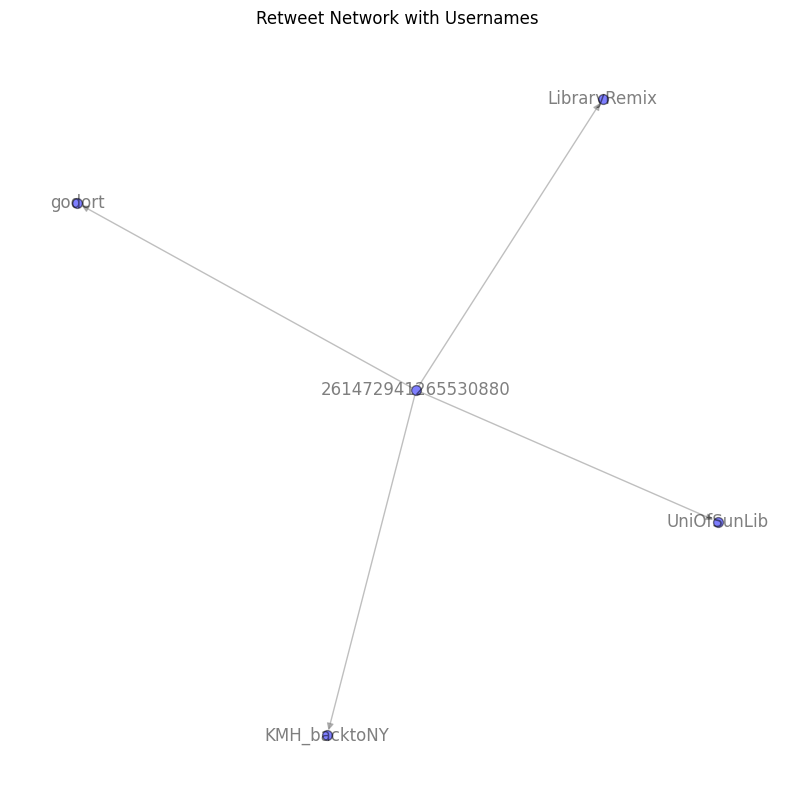

In [21]:
# Visualize the Graph
pos_fr = nx.spring_layout(G)
matplotlib.rcParams['figure.figsize'] = (10, 10)
plt.figure()
plt.axis("off")
plt.title('Retweet Network with Usernames')

# Create labels dictionary
labels = {}
for node, data in G.nodes(data=True):
    if 'username' in data: #Check if username exists.
        labels[node] = data['username']
    else:
        labels[node] = node #use node id if no username.

# Draw graph with labels
nx.draw_networkx(G, pos=pos_fr, node_size=50, node_color='blue', edge_color='gray', alpha=0.5, with_labels=True, labels=labels, edgecolors='black')
plt.show()